# Asset Pricing Analysis
## Comparison with Florackis et al., double sorts

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import wrds
from tqdm.notebook import tqdm
import glob
from tqdm.dask import TqdmCallback

In [3]:
#import functions from functions.py
from function_definitions import *

In [4]:
def get_returns_(cusip, db, start_date, end_date):
    Request = """select date, ret, shrout, prc, hsiccd from crsp.msf where cusip in ('{}')
              and date >= '{}' and date <='{}'""".format(cusip, start_date, end_date)
    data = db.raw_sql(Request)
    data.set_index('date', inplace = True)
    data.index = pd.to_datetime(data.index)
    data.index = data.index.to_period('M')
    #there are months with several observations for some reason
    data = data[~data.index.duplicated(keep='first')]
    #calculate market cap
    try:
        data['Market Cap'] = data['shrout']*1000*data['prc'].abs() #shrout in thousands
    except:
        data['Market Cap'] = None
    data.drop(columns = ['shrout', 'prc'], inplace = True)
    #drop returns that are missing (==-66, -77, -88 or -99)
    missing_returns = [-66, -77, -88, -99]
    data = data[~np.isin(data.ret, missing_returns)]
    #replace missing values from the industry classifications with NaN
    data[data.hsiccd == 0] = np.nan
    
    data.columns = [cusip, cusip, cusip]
    #return monthly returns, monthly market cap and Standard Industrial classification code
    return data.iloc[:,0], data.iloc[:,1], data.iloc[:,2]

## Sorting on Florackis' measure

In [7]:
#connect to WRDS
db = wrds.Connection(wrds_username = 'calex')

Loading library list...
Done


In [288]:
#use the measure from Florackis et al
gvkey_cusip = db.get_table(library = 'comp', table = 'funda', columns = ['cusip', 'gvkey']).drop_duplicates()
gvkey_cusip.cusip = gvkey_cusip.cusip.str.slice(stop = -1)

florackis_cybersec = pd.read_stata('../data/cyber_risk_measures/Florackis_original/flmw_rfs.dta')
florackis_cybersec.gvkey = florackis_cybersec.gvkey.astype(int).astype(str).str.zfill(6)
print(f' Initial number of firms in Florackis: {florackis_cybersec.gvkey.nunique()}')
florackis_cybersec = florackis_cybersec.merge(gvkey_cusip, left_on = 'gvkey', right_on = 'gvkey')
florackis_cybersec = florackis_cybersec.drop_duplicates(['fyear','cusip'])
florackis_cybersec = florackis_cybersec.pivot(index = 'fyear', columns = 'cusip', values = 'cyber_risk_score_cosine')

 Initial number of firms in Florackis: 6984


In [289]:
florackis_cybersec.stack().describe(percentiles = [0.01,0.25,0.50,0.75,0.99])

count    44972.000000
mean         0.237581
std          0.221395
min          0.000000
1%           0.000000
25%          0.000000
50%          0.275154
75%          0.445238
99%          0.609011
max          0.931028
dtype: float64

In [291]:
#get monthly stock returns for all firms using wrds and crsp
returns = []
market_caps = []
industry_codes = []
tickers = []
start_date = '2007-01-01'
end_date = '2018-12-01'
for i in tqdm(range(florackis_cybersec.shape[1]),desc = 'Getting monthly returns for all firms', leave = False):
    ret = get_returns_(florackis_cybersec.columns[i],db, start_date, end_date)
    returns.append(ret[0])
    industry_codes.append(ret[1])
    market_caps.append(ret[2])

Getting monthly returns for all firms:   0%|          | 0/6984 [00:00<?, ?it/s]

In [292]:
returns_df = pd.concat(returns, axis = 1).sort_index()
market_caps_df = pd.concat(market_caps, axis = 1).sort_index()

print(f'Firms with ret and mkt cap: {returns_df.shape[1]}')

Firms with ret and mkt cap: 6984


In [293]:
#CIK, CUSIP, GVKEY and ticker linking table
links = db.get_table(library = 'compa', table = 'funda ', columns = ['cusip', 'cik', 'gvkey','tic', 'conm'])
links.drop_duplicates(inplace = True)
links.dropna(inplace = True)
links.cusip = links.cusip.str.slice(stop = -1)

links = links[links.cusip.isin(returns_df.columns)]
links.cik = links.cik.astype(int)

In [294]:
#paths to the previously saved 10-K files
files_10k = np.sort(glob.glob("../data/SEC_idx_files/10-K/*"))

#find the url of the 10-K statement corresponding to each ticker in the dataset
years = np.arange(2007,2019) # 2007 to 2022
for file, year in zip(files_10k, years):
    with open(file, "r") as f:
        tenKs = f.read()
    
    lines = tenKs.split('\n')
    allpromises = []
    
    for line in lines[:-1]:
        allpromises.append(get_url(line))
    
    with TqdmCallback(desc = 'Finding urls for {}'.format(year), leave = False):
        temp = dask.compute(allpromises)
    
    #merge the resulting dictionnaries into one
    temp = {key: val for dict_ in temp[0] for key, val in dict_.items()}
    temp_df = pd.DataFrame(temp).T.reset_index()
    temp_df.columns = ['cik', 'url_{}'.format(year), 'filling_date_{}'.format(year), 'conm']
    temp_df.cik = temp_df.cik.astype(int)
    
    #merge the urls and filling dates onto the temp dataframe
    #merge on CIK when CIK is available
    links = links.merge(temp_df[['cik', 'url_{}'.format(year), 'filling_date_{}'.format(year)]],
                                  on = 'cik', how = 'left')
    
    #merge on company name when CIK is not available
    links = links.merge(temp_df[~np.isin(temp_df.cik,links.cik)], on = 'conm', how = 'left')
    links['cik']= links.cik_x.combine_first(links.cik_y)
    links['url_{}'.format(year)] = links['url_{}_x'.format(year)].combine_first(links['url_{}_y'.format(year)])
    links['filling_date_{}'.format(year)] = links['filling_date_{}_x'.format(year)].combine_first(links['filling_date_{}_y'.format(year)])
    links.drop(columns = ['cik_x', 'cik_y','filling_date_{}_x'.format(year),'url_{}_y'.format(year),
                               'filling_date_{}_y'.format(year),'url_{}_x'.format(year)], inplace = True)
    
print(f'Firms with at least one filling date: {links.filter(like = "filling").dropna(how = "all").shape[0]}')

Finding urls for 2007:   0%|          | 0/42870 [00:00<?, ?it/s]

Finding urls for 2008:   0%|          | 0/43730 [00:00<?, ?it/s]

Finding urls for 2009:   0%|          | 0/49195 [00:00<?, ?it/s]

Finding urls for 2010:   0%|          | 0/45825 [00:00<?, ?it/s]

Finding urls for 2011:   0%|          | 0/44200 [00:00<?, ?it/s]

Finding urls for 2012:   0%|          | 0/41965 [00:00<?, ?it/s]

Finding urls for 2013:   0%|          | 0/40525 [00:00<?, ?it/s]

Finding urls for 2014:   0%|          | 0/40420 [00:00<?, ?it/s]

Finding urls for 2015:   0%|          | 0/39925 [00:00<?, ?it/s]

Finding urls for 2016:   0%|          | 0/37945 [00:00<?, ?it/s]

Finding urls for 2017:   0%|          | 0/36240 [00:00<?, ?it/s]

Finding urls for 2018:   0%|          | 0/35460 [00:00<?, ?it/s]

Firms with at least one filling date: 6446


In [295]:
#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [296]:
dates = pd.date_range(start = '01-01-2008', end = '12-01-2018', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []
mkt_cap_quintiles = []

florackis_cybersec = florackis_cybersec.loc[:,florackis_cybersec.columns.isin(links.cusip)]
returns_df = returns_df.loc[:,returns_df.columns.isin(links.cusip)]

print(f'Firms with ret, mkt cap and filling dates: {florackis_cybersec.shape[1]}')

#drop firms with less than 3 years (table 7 caption)
florackis_cybersec = florackis_cybersec.loc[:,(~florackis_cybersec.isnull()).sum()>3]
print(f'Firms with over 3 years of observations: {florackis_cybersec.shape[1]}')

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = florackis_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = market_caps_df.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns_df.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns_df.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = links[[fd_col, 'cusip']].set_index('cusip')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = florackis_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort non-zero firms into two portfolios
        quintiles = pd.qcut(Cybersec[(Cybersec != 0)], q = 2,labels = False)
        
        quantile_weights = []
        for q in range(3):
            if q == 0:
                firms = Cybersec[(Cybersec == 0)].index
                zero_firms = firms
            else:
                firms = quintiles[quintiles == q-1].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
            risk_index_quintiles.append(Cybersec[firms].mean()) #quantile_weights[q]
            mkt_cap_quintiles.append(mkt_caps_.loc[firms].mean()/10000)
        
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(3):
        if q == 0:
            firms = zero_firms
        else:
            firms = quintiles[quintiles == q-1].index
        quantile_ret = returns_df.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = florackis_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = links[[fd_col, 'cusip']].set_index('cusip')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = florackis_cybersec.loc[month.year-1,idx_not_filled]
        #risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(3)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,3))
nb_firms = np.reshape(nb_firms,(-1,3))
mkt_cap_quintiles = np.reshape(mkt_cap_quintiles, (-1,3))

Firms with ret, mkt cap and filling dates: 6523
Firms with over 3 years of observations: 4619


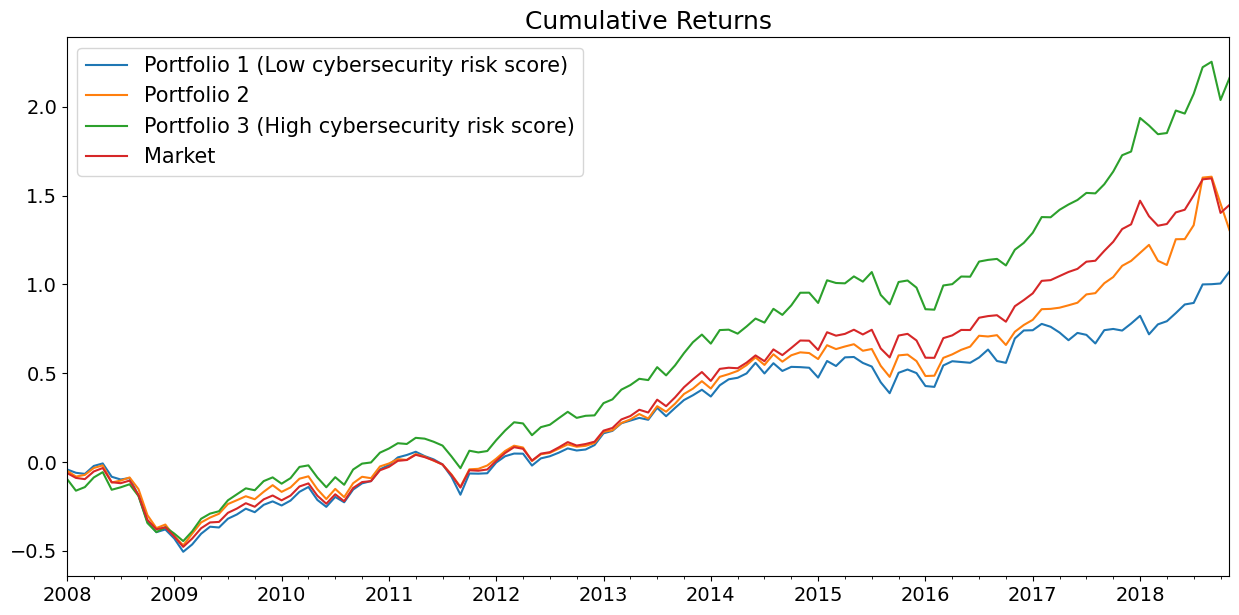

In [297]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2',
            'Portfolio 3 (High cybersecurity risk score)',
            'Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [298]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas_(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized Ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.64%,0.71%,0.95%,0.31%
CAPM alpha,-0.12%,-0.03%,0.20%,0.32%
FFC alpha,-0.07%,-0.03%,0.18%,0.25%
FF5 alpha,-0.07%,-0.01%,0.21%,0.28%


p-values:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.173,0.092,0.023,0.092
CAPM alpha,0.464,0.687,0.073,0.115
FFC alpha,0.690,0.750,0.062,0.210
FF5 alpha,0.659,0.952,0.067,0.142


t stats:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,1.362,1.685,2.275,1.685
CAPM alpha,-0.732,-0.403,1.796,1.576
FFC alpha,-0.399,-0.319,1.866,1.254
FF5 alpha,-0.441,-0.060,1.829,1.467


Annualized Ratios:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Annualized Sharpe Ratio,0.4631,0.5333,0.7284,0.5012
Annualized Treynor Ratio,0.02176,0.02477,0.03291,-2.239
Annualized Sortino Ratio,0.6691,0.7772,1.07,2.292


In [299]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([3,3]), index = ['Number of firms', 'Cyber risk index', 'Mkt value/10000 (ln)'],
                      columns = ['Q1 (low)', 'Q2', 'Q3 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)
tableB.loc['Mkt value/10000 (ln)',:] = np.mean(np.log(mkt_cap_quintiles), axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3 (high)
Number of firms,1174.591,922.886,922.341
Cyber risk index,0.000,0.318,0.471
Mkt value/10000 (ln),12.431,13.367,13.450


In [300]:
florackis_cybersec.stack().describe(percentiles = [0.01,0.25,0.50,0.75,0.99])

count    39004.000000
mean         0.243558
std          0.220998
min          0.000000
1%           0.000000
25%          0.000000
50%          0.291341
75%          0.448761
99%          0.608976
max          0.931028
dtype: float64

## Comparison with the measure of Florackis

In [8]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

In [9]:
#use the measure from Florackis et al
gvkey_cusip = db.get_table(library = 'comp', table = 'funda', columns = ['cusip', 'gvkey']).drop_duplicates()
gvkey_cusip.cusip = gvkey_cusip.cusip.str.slice(stop = -1)
cusip_ticker = db.get_table(library='crsp', table = 'stocknames', columns = ['cusip','ticker','nameenddt']).drop_duplicates()
#keep latest ticker for each CUSIP
cusip_ticker.nameenddt = pd.to_datetime(cusip_ticker.nameenddt)
cusip_ticker = cusip_ticker.loc[cusip_ticker.groupby(['cusip']).nameenddt.idxmax(),:]
#cusip_ticker.drop(columns = ['nameenddt'], inplace = True)

gvkey_ticker = cusip_ticker.merge(gvkey_cusip, left_on = 'cusip', right_on = 'cusip')

florackis_cybersec = pd.read_stata('../data/cyber_risk_measures/Florackis_original/flmw_rfs.dta')
florackis_cybersec.gvkey = florackis_cybersec.gvkey.astype(int).astype(str).str.zfill(6)
print(f' Initial number of firms in Florackis: {florackis_cybersec.gvkey.nunique()}')
florackis_cybersec = florackis_cybersec.merge(gvkey_ticker[['ticker','gvkey']], left_on = 'gvkey', right_on = 'gvkey')
florackis_cybersec = florackis_cybersec.drop_duplicates(['fyear','ticker'])
florackis_cybersec = florackis_cybersec.pivot(index = 'fyear', columns = 'ticker', values = 'cyber_risk_score_cosine')

 Initial number of firms in Florackis: 6984


In [10]:
florackis_cybersec.stack().describe(percentiles = [0.01,0.25,0.50,0.99])

count    41997.000000
mean         0.241936
std          0.221741
min          0.000000
1%           0.000000
25%          0.000000
50%          0.286759
99%          0.609817
max          0.931028
dtype: float64

In [11]:
print(f'Number of firms in Florackis: {florackis_cybersec.shape[1]}')
print(f'Number of firms in our sample: {general_cybersec.shape[1]}')

#limit to common firms
cols = list(reduce(set.intersection, (set(general_cybersec.columns), set(florackis_cybersec.columns))))
general_cybersec = general_cybersec.loc[general_cybersec.index.isin(florackis_cybersec.index),cols]
florackis_cybersec = florackis_cybersec.loc[:,cols]

print(f'Number of common firms: {general_cybersec.shape[1]}')

Number of firms in Florackis: 6251
Number of firms in our sample: 6878
Number of common firms: 4240


In [12]:
corr = pd.concat([general_cybersec.stack(),florackis_cybersec.stack()], axis = 1).corr().iloc[0,1]
print(f'The correlation of my measure with the one from Florackis et al is {round(corr,2)}')

The correlation of my measure with the one from Florackis et al is 0.34


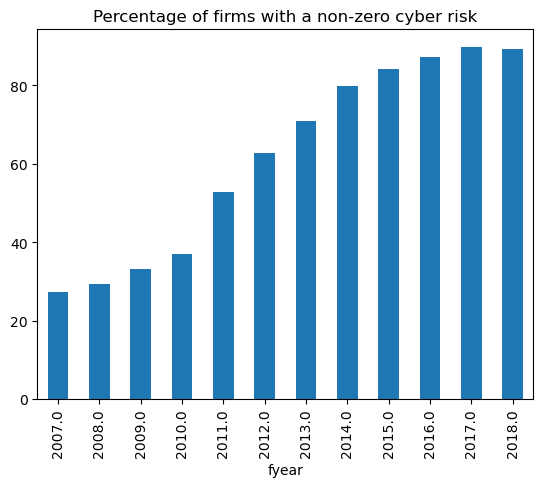

In [13]:
#percentage of firms with a non-zero cyber risk
(100-(florackis_cybersec == 0).sum(1)/(~florackis_cybersec.isna()).sum(1)*100).plot.bar()
plt.title('Percentage of firms with a non-zero cyber risk')
plt.show()

### Cyber risk of cybersecurity firms

In [303]:
#read in the holdings of the HACK ETF
HACK_holdings = pd.read_csv('../data/HACK_fund_holdings.csv')
#identify firms that are in my sample
cyber_firms = HACK_holdings.loc[HACK_holdings.StockTicker.isin(stocknames.ticker),'StockTicker'].values

In [304]:
florackis_cybersec.loc[:,florackis_cybersec.columns.isin(cyber_firms)]
#florackis_cybersec.mean(1)
#florackis_cybersec.apply(lambda row: row.rank(pct=True).loc['PANW'], axis=1)
#florackis_cybersec.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

ticker,BAH,S,QLYS,NTCT,SPLK,SCWX,SAIC,RPD,ZS,OKTA,...,ATEN,CVLT,FFIV,EVBG,FTNT,SWI,PANW,CSCO,LDOS,JNPR
fyear,,,,,,,,,,,,,,,,,,,,,
2007.0,NaN,0.193952,NaN,0.069285,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.428185,0.083574
2008.0,NaN,0.274082,NaN,0.188981,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.327418,0.000000,NaN,NaN,NaN,NaN,0.312936,0.931028,0.056374
2009.0,NaN,0.310273,NaN,0.062273,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.400297,0.000000,NaN,0.368147,0.369698,NaN,0.354719,0.361579,0.047952
2010.0,0.353211,0.220995,NaN,0.076093,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.512340,0.000000,NaN,0.253252,0.414953,NaN,0.253403,0.432830,0.038387
2011.0,0.337697,0.396494,NaN,0.338600,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.386082,0.000000,NaN,0.330450,0.262245,NaN,0.299488,0.442443,0.422120
2012.0,0.441949,0.358263,0.421549,0.400281,0.575011,NaN,NaN,NaN,NaN,NaN,...,NaN,0.443007,0.240543,NaN,0.332915,0.362083,0.350717,0.262724,0.488035,0.368117
2013.0,0.458730,0.431833,0.379857,0.433286,0.551137,NaN,0.472911,NaN,NaN,NaN,...,NaN,0.475990,0.342721,NaN,0.388241,0.490609,0.411071,0.315662,0.479577,0.421985
2014.0,0.445979,0.411144,0.421209,0.405684,0.581246,NaN,0.529428,NaN,NaN,NaN,...,0.527039,0.500592,0.281369,NaN,0.373260,0.510111,0.416626,0.326933,0.519922,0.468597
2015.0,0.526610,0.482571,0.426574,0.520120,0.572456,NaN,0.552241,0.500484,NaN,NaN,...,0.555891,0.542354,0.318062,NaN,0.396779,NaN,0.436583,0.304427,NaN,0.508686


In [305]:
general_cybersec.loc[:,general_cybersec.columns.isin(cyber_firms)]

,BAH,S,QLYS,NTCT,SPLK,SCWX,SAIC,RPD,ZS,OKTA,...,ATEN,CVLT,FFIV,EVBG,FTNT,SWI,PANW,CSCO,LDOS,JNPR
2008,NaN,NaN,NaN,0.574458,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.579920,0.613288,NaN,NaN,NaN,NaN,0.588822,0.514070,0.564826
2009,NaN,NaN,NaN,0.578210,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.577293,0.605548,NaN,NaN,NaN,NaN,0.580374,0.521633,0.568755
2010,NaN,NaN,NaN,0.568676,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.583375,0.604628,NaN,0.617646,NaN,NaN,0.589309,0.519906,0.566827
2011,0.513806,NaN,NaN,0.576890,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.596796,0.610439,NaN,0.618578,NaN,NaN,0.568584,0.523241,0.563001
2012,0.524804,NaN,NaN,0.578880,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.596205,0.611129,NaN,0.608961,NaN,0.602201,0.582163,0.546783,0.576803
2013,0.550617,NaN,0.601935,0.584130,0.609208,NaN,NaN,NaN,NaN,NaN,...,NaN,0.598630,0.594851,NaN,0.611199,NaN,0.607210,0.563182,0.557954,0.577196
2014,0.550541,NaN,0.614469,0.576216,0.623508,NaN,0.547685,NaN,NaN,NaN,...,NaN,0.602789,0.605492,NaN,0.611140,NaN,0.620241,0.574269,0.564409,0.581199
2015,0.553471,NaN,0.621578,0.571220,0.636564,NaN,0.532572,NaN,NaN,NaN,...,0.584896,0.602217,0.619180,NaN,0.612143,NaN,0.623814,0.577032,0.545785,0.575040
2016,0.540691,NaN,0.616339,0.582036,0.611456,NaN,0.541555,0.623044,NaN,NaN,...,0.589337,0.610913,0.607262,NaN,0.616344,NaN,0.626958,0.571014,NaN,0.580484
2017,0.551766,NaN,0.610127,0.572112,0.615565,0.599564,0.541508,0.597692,NaN,NaN,...,0.600772,0.610379,0.611752,0.588203,0.632475,NaN,0.623457,0.571854,0.549387,0.577847


### Interesting discrepancies where firms have zero risk:
* __STX__, 2008 (p. 32):  System Failures—System failures caused by events beyond our control could adversely affect computer equipment and electronic data on which our operations depend.
    * Our operations are dependent upon our ability to protect our computer equipment and the electronic data stored in our databases from damage by, among other things, earthquake, fire, natural disaster, power loss, telecommunications failures, unauthorized intrusion and other catastrophic events. As our operations become more automated and increasingly interdependent, our exposure to the risks posed by these types of events will increase. While we continue to improve our disaster recovery processes, system failures and other interruptions in our operations could have a material adverse effect on our business, results of operations and financial condition. 
    
    
* __MANH__, 2014 (p. 20): Our software may contain undetected errors or “bugs” resulting in harm to our reputation which could adversely impact our business, results of operations, cash flow, and financial condition.
    * Software products as complex as those offered by us might contain undetected errors or failures when first introduced or when new versions are released,. Despite testing, we cannot ensure that errors will not be found in new products or product enhancements after commercial release,. Any errors could cause substantial harm to our reputation, result in additional unplanned expenses to remedy any defects, delay the introduction of new products, result in the loss of existing or potential customers, or cause a loss in revenue. Further, such errors could subject us to claims from our customers for significant damages, and we cannot assure you that courts would enforce the provisions in our customer agreements that limit our liability for damages. In turn, our business, results of operations, cash flow, and financial condition could be materially adversely affected. 
    

* __MBCN__, 2017 (p.22): Material breaches in security of bank systems may have a significant effect on the Company business.
    * We collect, process and store sensitive consumer data by utilizing computer systems and telecommunications networks operated by both banks and third party service providers. We have security, backup and recovery systems in place, as well as a business continuity plan to ensure systems will not be inoperable. We also have security to prevent unauthorized access to the system. In addition, we require third party service providers to maintain similar controls. However, we cannot be certain that these measures will be successful. A security breach in the system and loss of confidential information could result in losing customers’ confidence and thus the loss of their business as well as additional significant costs for privacy monitoring activities.

In [306]:
florackis_cybersec[['STX','MANH','MBCN']]

ticker,STX,MANH,MBCN
fyear,,,
2007.0,NaN,0.000000,NaN
2008.0,0.000000,0.000000,NaN
2009.0,0.000000,0.000000,NaN
2010.0,0.000000,0.000000,NaN
2011.0,0.000000,0.257652,NaN
2012.0,0.396673,0.256148,NaN
2013.0,0.543426,0.325037,NaN
2014.0,0.508454,0.000000,0.0
2015.0,0.536000,0.000000,0.0


In [307]:
general_cybersec[['STX','MANH','MBCN']]

,STX,MANH,MBCN
2008,0.546983,0.541096,0.503235
2009,0.555139,0.532746,0.482456
2010,0.556882,0.551043,0.533970
2011,0.576379,0.553211,0.533970
2012,0.566522,0.576169,0.513959
2013,0.562834,0.571742,0.536652
2014,0.570125,0.562404,0.534739
2015,0.572748,0.576395,0.551849
2016,0.576664,0.576395,0.551849
2017,0.588148,0.564271,0.577073


### Univariate portfolio sorts (same firms as Florackis and 3 portfolios)

In [6]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'

returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan
#use the measure from Florackis et al
gvkey_cusip = db.get_table(library = 'comp', table = 'funda', columns = ['cusip', 'gvkey']).drop_duplicates()
gvkey_cusip.cusip = gvkey_cusip.cusip.str.slice(stop = -1)
cusip_ticker = db.get_table(library='crsp', table = 'stocknames', columns = ['cusip','ticker','nameenddt']).drop_duplicates()
#keep latest ticker for each CUSIP
cusip_ticker.nameenddt = pd.to_datetime(cusip_ticker.nameenddt)
cusip_ticker = cusip_ticker.loc[cusip_ticker.groupby(['cusip']).nameenddt.idxmax(),:]
#cusip_ticker.drop(columns = ['nameenddt'], inplace = True)
gvkey_ticker = cusip_ticker.merge(gvkey_cusip, left_on = 'cusip', right_on = 'cusip')

florackis_cybersec = pd.read_stata('../data/cyber_risk_measures/Florackis_original/flmw_rfs.dta')
florackis_cybersec.gvkey = florackis_cybersec.gvkey.astype(int).astype(str).str.zfill(6)
florackis_cybersec = florackis_cybersec.merge(gvkey_ticker[['ticker','gvkey']], left_on = 'gvkey', right_on = 'gvkey')
florackis_cybersec = florackis_cybersec.drop_duplicates(['fyear','ticker'])
florackis_cybersec = florackis_cybersec.pivot(index = 'fyear', columns = 'ticker', values = 'cyber_risk_score_cosine')

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#limit to common firms
cols = list(reduce(set.intersection, (set(general_cybersec.columns), set(florackis_cybersec.columns))))
general_cybersec = general_cybersec.loc[general_cybersec.index.isin(florackis_cybersec.index),cols]
florackis_cybersec = florackis_cybersec.loc[:,cols]

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [7]:
#from Florackis internet appendix, Table IA.1
p1_proportion = pd.Series([0.29,0.31,0.35,0.39,0.55,0.66,0.73,0.80,0.85,0.88,0.90,0.89],
                             index = range(2007,2019))
p1_proportion = 1-p1_proportion

In [27]:
dates = pd.date_range(start = '03-01-2008', end = '12-01-2018', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        if (month.year == 2008):
            Cybersec.loc[idx_not_filled] = np.nan
        else:
            Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into terciles
        prop_p1 = p1_proportion[month.year]
        quintiles = pd.qcut(Cybersec, q = [0,prop_p1, prop_p1 + (1-prop_p1)/2,1],labels = False)
        #quintiles = pd.qcut(Cybersec, q = 3,labels = False)

        quantile_weights = []
        for q in range(3):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(3):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        #take the previous year's cyber score
        if (month.year == 2008):
            cyber.loc[idx_not_filled] = np.nan
        else:
            cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(3)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,3))
nb_firms = np.reshape(nb_firms,(-1,3))

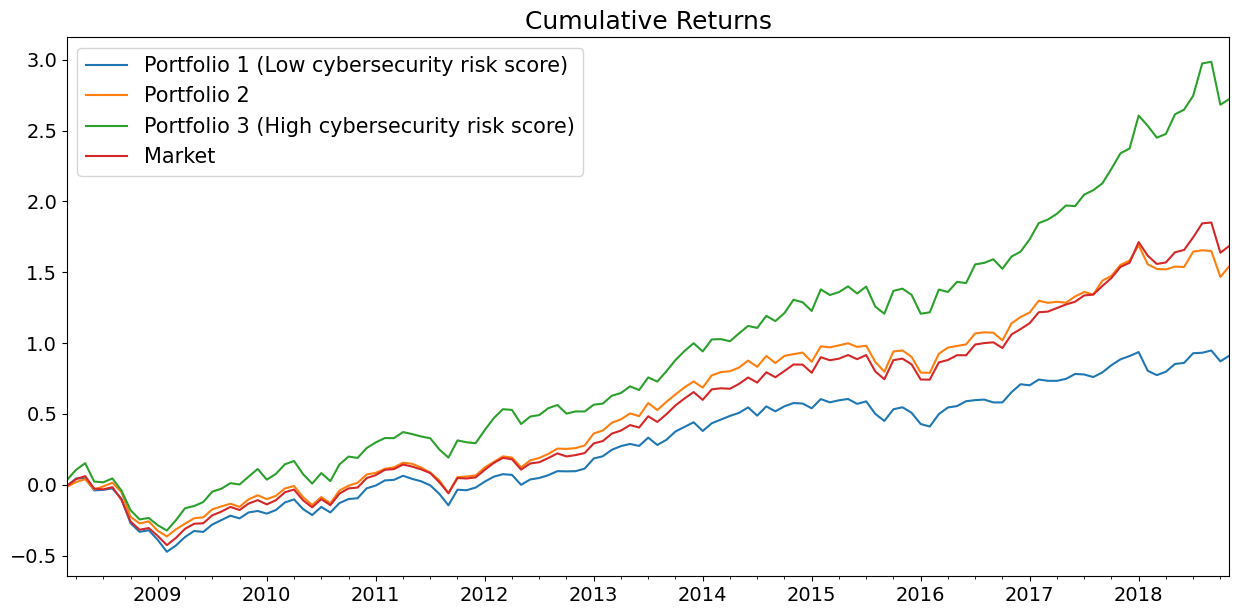

In [28]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2',
            'Portfolio 3 (High cybersecurity risk score)',
            'Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [29]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas_(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized Ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.57%,0.79%,1.09%,0.52%
CAPM alpha,-0.25%,-0.00%,0.28%,0.53%
FFC alpha,-0.18%,0.02%,0.23%,0.41%
FF5 alpha,-0.20%,0.00%,0.23%,0.43%


p-values:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.183,0.036,0.002,0.003
CAPM alpha,0.010,0.998,0.024,0.008
FFC alpha,0.035,0.828,0.054,0.024
FF5 alpha,0.013,0.995,0.076,0.020


t stats:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,1.330,2.093,3.162,2.942
CAPM alpha,-2.591,-0.002,2.257,2.635
FFC alpha,-2.107,0.217,1.926,2.259
FF5 alpha,-2.492,0.006,1.773,2.326


Annualized Ratios:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Annualized Sharpe Ratio,0.4425,0.6406,0.8536,0.82
Annualized Treynor Ratio,0.02012,0.02887,0.03896,-1.901
Annualized Sortino Ratio,0.6124,0.9315,1.335,3.194


In [17]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,3]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3 (high)
Number of firms,874.976,874.238,874.571
Cyber risk index,0.492,0.512,0.556


In [467]:
florackis_cybersec.stack().describe(percentiles = [0.01,0.25,0.50,0.99])

count    31818.000000
mean         0.249532
std          0.221422
min          0.000000
1%           0.000000
25%          0.000000
50%          0.302362
99%          0.610650
max          0.931028
dtype: float64

In [495]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2018', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
florackis_cybersec = florackis_cybersec.loc[:,(~florackis_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = florackis_cybersec.loc[month.year,:]#.dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index]#.dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = florackis_cybersec.loc[month.year-1,idx_not_filled]
        #Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort non-zero firms into two portfolios
        quintiles = pd.qcut(Cybersec[Cybersec != 0], q = 2,labels = False)
        
        quantile_weights = []
        for q in range(3):
            if q == 0:
                firms = Cybersec[(Cybersec == 0) | (Cybersec.isna())].index
                zero_firms = firms
            else:
                firms = quintiles[quintiles == q-1].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(3):
        if q == 0:
            firms = zero_firms
        else:
            firms = quintiles[quintiles == q-1].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = florackis_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = florackis_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(3)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,3))
nb_firms = np.reshape(nb_firms,(-1,3))

143
160
157
149
144
131
135
133
134
132
121
98
93
81
74
57
50
73
70
55
42
118
113
88
87
131
124
113
104
85
75
68
68
105
90
81
103
2115
2320
2362


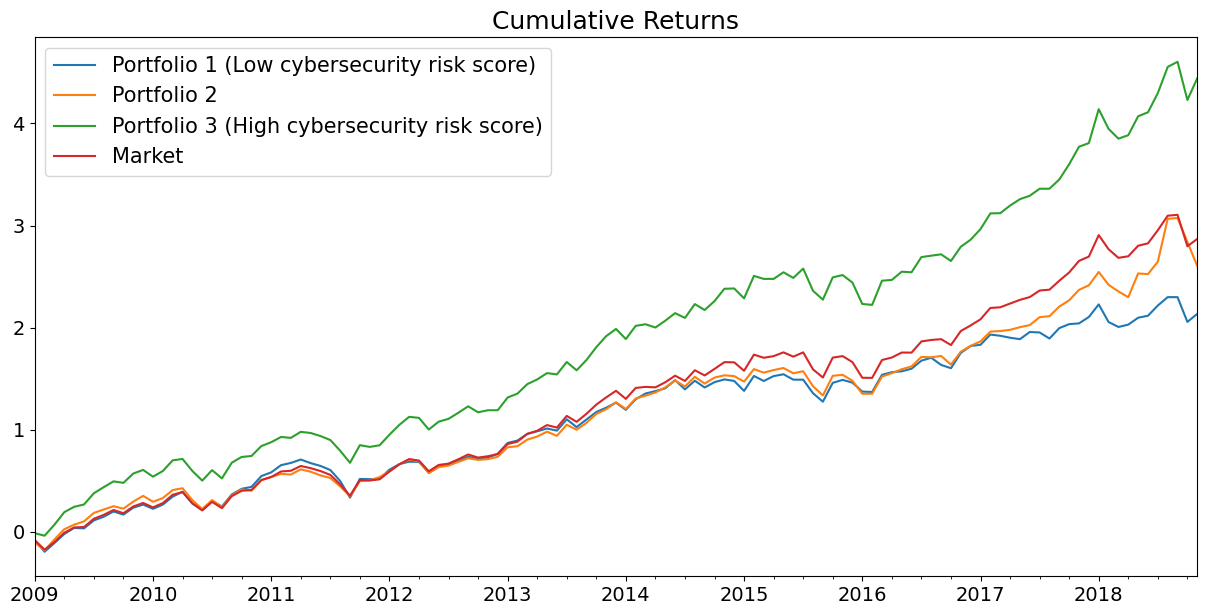

In [496]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2',
            'Portfolio 3 (High cybersecurity risk score)',
            'Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [497]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas_(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized Ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,1.03%,1.15%,1.48%,0.45%
CAPM alpha,-0.21%,-0.05%,0.38%,0.59%
FFC alpha,-0.14%,-0.05%,0.30%,0.45%
FF5 alpha,-0.15%,-0.05%,0.31%,0.47%


p-values:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.000,0.000,0.000,0.028
CAPM alpha,0.068,0.491,0.089,0.033
FFC alpha,0.142,0.522,0.060,0.034
FF5 alpha,0.077,0.566,0.088,0.031


t stats:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,3.803,4.328,4.915,2.192
CAPM alpha,-1.825,-0.689,1.699,2.128
FFC alpha,-1.468,-0.641,1.878,2.120
FF5 alpha,-1.771,-0.574,1.707,2.163


Annualized Ratios:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Annualized Sharpe Ratio,0.8484,0.947,1.362,0.8933
Annualized Treynor Ratio,0.03444,0.03955,0.05594,-0.4345
Annualized Sortino Ratio,1.382,1.631,2.649,6.213


In [498]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,3]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3 (high)
Number of firms,1100.925,807.400,807.000
Cyber risk index,0.007,0.331,0.465


### Univariate portfolio sorts (3 portfolios of zero-Florackis risk firms)

In [17]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'

returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [18]:
#use the measure from Florackis et al
gvkey_cusip = db.get_table(library = 'comp', table = 'funda', columns = ['cusip', 'gvkey']).drop_duplicates()
gvkey_cusip.cusip = gvkey_cusip.cusip.str.slice(stop = -1)
cusip_ticker = db.get_table(library='crsp', table = 'stocknames', columns = ['cusip','ticker','nameenddt']).drop_duplicates()
#keep latest ticker for each CUSIP
cusip_ticker.nameenddt = pd.to_datetime(cusip_ticker.nameenddt)
cusip_ticker = cusip_ticker.loc[cusip_ticker.groupby(['cusip']).nameenddt.idxmax(),:]
#cusip_ticker.drop(columns = ['nameenddt'], inplace = True)

gvkey_ticker = cusip_ticker.merge(gvkey_cusip, left_on = 'cusip', right_on = 'cusip')

florackis_cybersec = pd.read_stata('../data/cyber_risk_measures/Florackis_original/flmw_rfs.dta')
florackis_cybersec.gvkey = florackis_cybersec.gvkey.astype(int).astype(str).str.zfill(6)
florackis_cybersec = florackis_cybersec.merge(gvkey_ticker[['ticker','gvkey']], left_on = 'gvkey', right_on = 'gvkey')
florackis_cybersec = florackis_cybersec.drop_duplicates(['fyear','ticker'])
florackis_cybersec = florackis_cybersec.pivot(index = 'fyear', columns = 'ticker', values = 'cyber_risk_score_cosine')

In [19]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2018', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

#list of zero-risk firms per year 
zero_risk_firms = florackis_cybersec.apply(lambda row: florackis_cybersec.columns[row == 0].tolist(), axis=1)

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]
        
        #only keep firms with zero-risk using the measure of Florackis et al
        Cybersec = Cybersec[Cybersec.index.isin(zero_risk_firms[month.year])]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 3, labels = False)

        quantile_weights = []
        for q in range(3):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(3):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(3)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,3))
nb_firms = np.reshape(nb_firms,(-1,3))

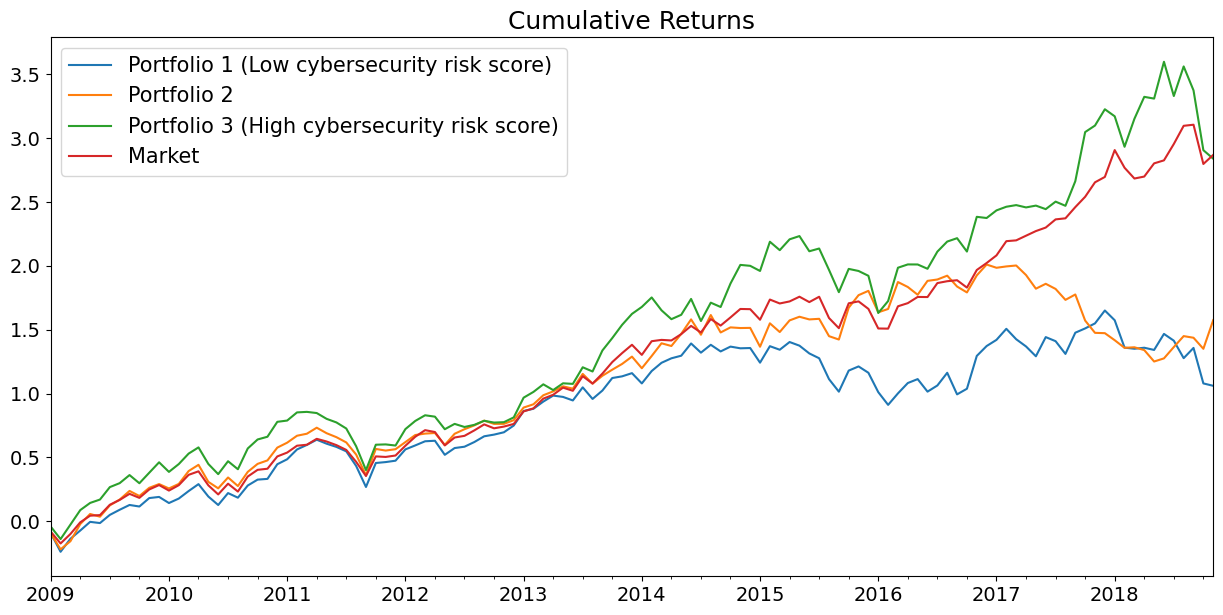

In [20]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2',
            'Portfolio 3 (High cybersecurity risk score)',
            'Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

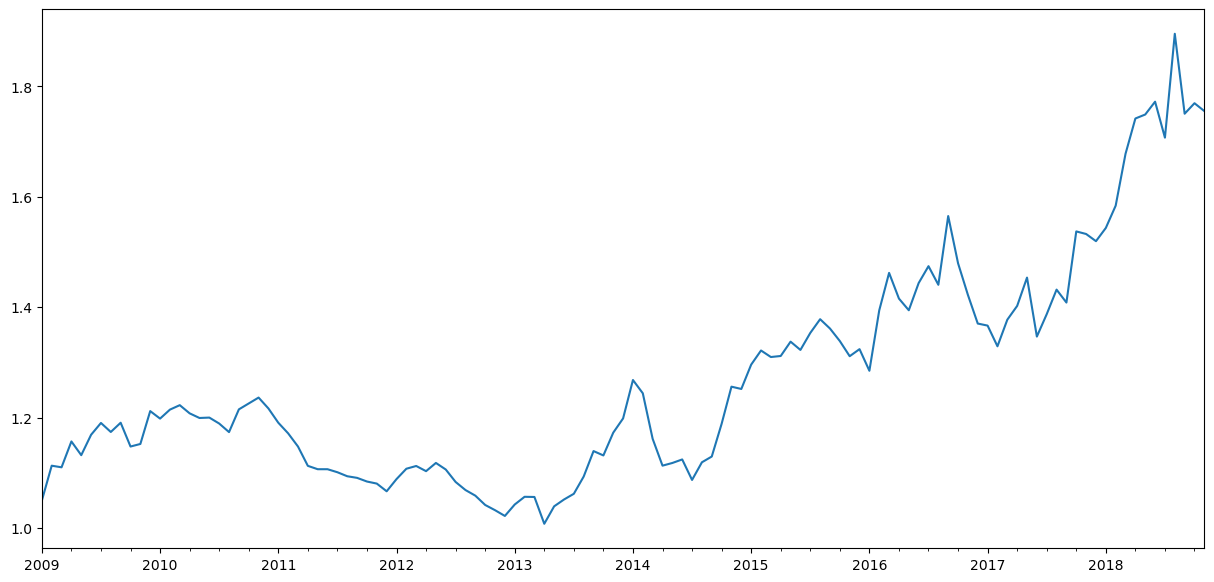

In [21]:
#plot the cumulative returns of the long-short portfolio
((vw_ret.quintile_2-vw_ret.quintile_0)+1).cumprod().plot(figsize = (15,7))
plt.show()

In [23]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas_(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.71%,0.88%,1.24%,0.52%
CAPM alpha,-0.58%,-0.35%,-0.07%,0.51%
FFC alpha,-0.40%,-0.23%,-0.05%,0.34%
FF5 alpha,-0.37%,-0.27%,0.01%,0.39%


p-values:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,0.067,0.024,0.001,0.046
CAPM alpha,0.006,0.266,0.723,0.084
FFC alpha,0.059,0.412,0.737,0.169
FF5 alpha,0.083,0.331,0.930,0.125


t stats:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Excess return,1.829,2.251,3.368,1.996
CAPM alpha,-2.745,-1.113,-0.354,1.728
FFC alpha,-1.887,-0.820,-0.336,1.376
FF5 alpha,-1.735,-0.973,0.087,1.535


Annualized ratios:


,Q1 (low),Q2,Q3 (high),Q3-Q1
Annualized Sharpe Ratio,0.4892,0.6446,0.8556,0.5671
Annualized Treynor Ratio,0.02278,0.02957,0.03918,3.976
Annualized Sortino Ratio,0.7345,1.071,1.463,2.349


In [24]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,3]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3 (high)
Number of firms,248.500,247.950,248.250
Cyber risk index,0.486,0.504,0.534


## Double sorts

In [230]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'

returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
betas = pd.read_csv(read_path+'mkt_betas.csv.gz', index_col = 'date')
book_to_market = pd.read_csv(read_path+'book_to_market.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)
betas.index = pd.to_datetime(betas.index)
book_to_market.index = pd.to_datetime(book_to_market.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

### Double sorted on beta

In [246]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]
        #drop firms with no betas the previous month
        betas_ = betas.loc[dates[i-1],betas.columns.isin(Cybersec.index)].dropna()
        Cybersec = Cybersec.loc[betas_.index]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]
        betas_ = betas_.loc[betas_.index.isin(Cybersec.index)]

        #sort firms into quintiles along market beta
        quintiles_beta = pd.qcut(betas_, q = 5, labels = False)
        
        #sort firms into quintiles along cyber risk
        quintiles_cyber = pd.Series(dtype = 'int64').reindex_like(quintiles_beta)
        for q in range(5):
            temp = pd.qcut(Cybersec[quintiles_beta[quintiles_beta == q].index], q = 5, labels = False)
            quintiles_cyber[quintiles_cyber.index.isin(temp.index)] = temp
            
        #join the two sorts
        quintiles = pd.concat([quintiles_cyber,quintiles_beta], axis = 1, keys = ['cyber','beta'])
        quintiles['overall'] = quintiles.beta*5+quintiles.cyber

        quantile_weights = []
        for q in range(25):
            firms = quintiles[quintiles.overall == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(25):
        firms = quintiles[quintiles.overall == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(25)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,25))
nb_firms = np.reshape(nb_firms,(-1,25))

In [247]:
print("Value weighted portfolios' excess returns")
table = pd.DataFrame(vw_ret.mean().values.reshape(5,5),
                     index = ['Beta Q1 (Low)', 'Beta Q2', 'Beta Q3', 'Beta Q4', 'Beta Q5 (High)'],
                     columns = ['Cyber Q1 (Low)', 'Cyber Q2', 'Cyber Q3', 'Cyber Q4', 'Cyber Q5 (High)'])
display(table.style.format("{:.2%}"))

Value weighted portfolios' excess returns


,Cyber Q1 (Low),Cyber Q2,Cyber Q3,Cyber Q4,Cyber Q5 (High)
Beta Q1 (Low),0.94%,1.01%,0.85%,1.09%,0.91%
Beta Q2,1.04%,1.03%,1.23%,1.25%,1.55%
Beta Q3,0.98%,1.22%,1.25%,1.36%,1.39%
Beta Q4,1.36%,1.19%,1.38%,1.29%,1.96%
Beta Q5 (High),1.61%,1.71%,1.79%,1.86%,1.72%


### Double sorted on book-to-market

In [221]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]
        #drop firms with no betas the previous month
        book_to_market_ = book_to_market.loc[dates[i-1],book_to_market.columns.isin(Cybersec.index)].dropna()
        Cybersec = Cybersec.loc[book_to_market_.index]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]
        book_to_market_ = book_to_market_.loc[book_to_market_.index.isin(Cybersec.index)]

        #sort firms into quintiles along book to market
        quintiles_BM = pd.qcut(book_to_market_, q = 5, labels = False)
        
        #sort firms into quintiles along cyber risk
        quintiles_cyber = pd.Series(dtype = 'int64').reindex_like(quintiles_BM)
        for q in range(5):
            temp = pd.qcut(Cybersec[quintiles_BM[quintiles_BM == q].index], q = 5, labels = False)
            quintiles_cyber[quintiles_cyber.index.isin(temp.index)] = temp
            
        #join the two sorts
        quintiles = pd.concat([quintiles_cyber,quintiles_BM], axis = 1, keys = ['cyber','BM'])
        quintiles['overall'] = quintiles.BM*5+quintiles.cyber

        quantile_weights = []
        for q in range(25):
            firms = quintiles[quintiles.overall == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(25):
        firms = quintiles[quintiles.overall == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(25)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,25))
nb_firms = np.reshape(nb_firms,(-1,25))

In [222]:
print("Value weighted portfolios' excess returns")
table = pd.DataFrame(vw_ret.mean().values.reshape(5,5),
                     index = ['BM Q1 (Low)', 'BM Q2', 'BM Q3', 'BM Q4', 'BM Q5 (High)'],
                     columns = ['Cyber Q1 (Low)', 'Cyber Q2', 'Cyber Q3', 'Cyber Q4', 'Cyber Q5 (High)'])
display(table.style.format("{:.2%}"))

Value weighted portfolios' excess returns


,Cyber Q1 (Low),Cyber Q2,Cyber Q3,Cyber Q4,Cyber Q5 (High)
BM Q1 (Low),0.90%,1.09%,1.22%,1.28%,1.54%
BM Q2,1.02%,1.09%,1.32%,1.23%,1.36%
BM Q3,0.99%,1.04%,1.23%,1.18%,1.51%
BM Q4,1.04%,1.17%,1.29%,1.25%,1.37%
BM Q5 (High),1.87%,1.77%,1.73%,1.64%,1.71%


### Double sorted on size

In [223]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]
        
        #sort firms into quintiles along mkt cap
        quintiles_Size = pd.qcut(mkt_caps_, q = 5, labels = False)
        
        #sort firms into quintiles along cyber risk
        quintiles_cyber = pd.Series(dtype = 'int64').reindex_like(quintiles_Size)
        for q in range(5):
            temp = pd.qcut(Cybersec[quintiles_Size[quintiles_Size == q].index], q = 5, labels = False)
            quintiles_cyber[quintiles_cyber.index.isin(temp.index)] = temp
            
        #join the two sorts
        quintiles = pd.concat([quintiles_cyber,quintiles_Size], axis = 1, keys = ['cyber','Size'])
        quintiles['overall'] = quintiles.Size*5+quintiles.cyber

        quantile_weights = []
        for q in range(25):
            firms = quintiles[quintiles.overall == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(25):
        firms = quintiles[quintiles.overall == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(25)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,25))
nb_firms = np.reshape(nb_firms,(-1,25))

In [224]:
print("Value weighted portfolios' excess returns")
table = pd.DataFrame(vw_ret.mean().values.reshape(5,5),
                     index = ['Size Q1 (Small)', 'Size Q2', 'Size Q3', 'Size Q4', 'Size Q5 (Large)'],
                     columns = ['Cyber Q1 (Low)', 'Cyber Q2', 'Cyber Q3', 'Cyber Q4', 'Cyber Q5 (High)'])
display(table.style.format("{:.2%}"))

Value weighted portfolios' excess returns


,Cyber Q1 (Low),Cyber Q2,Cyber Q3,Cyber Q4,Cyber Q5 (High)
Size Q1 (Small),1.33%,1.25%,1.45%,1.77%,1.24%
Size Q2,1.35%,1.54%,1.23%,1.18%,1.38%
Size Q3,1.43%,1.39%,1.19%,1.33%,1.47%
Size Q4,1.16%,1.21%,1.29%,1.24%,1.30%
Size Q5 (Large),0.86%,1.00%,1.14%,1.25%,1.52%
